## Import Modules

In [27]:
# General utilities
import os
import glob
import warnings
import pandas as pd
import scipy as sp
import numpy as np
from tqdm import tqdm, trange
from natsort import natsorted
import multiprocessing as mp

# Image processing and IO
import tifffile as tiff
import skimage.io as io
from scipy import ndimage, misc
from skimage.feature import peak_local_max
import cv2

# Plotting and animation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as cbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.widgets import Slider
from matplotlib import animation, rc
from IPython.display import display, Image

# GPU and optimized operations
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage

# Statistical and optimization tools
from scipy.stats import chi2
from scipy.optimize import curve_fit

# Video processing
from moviepy.editor import ImageSequenceClip
from moviepy.video.io.bindings import mplfig_to_npimage

# Trackpy and related modules
import trackpy as tp

# Warnings configuration
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore outdated warnings

# Set up animation display
rc('animation', html='jshtml')
matplotlib.rcParams['animation.embed_limit'] = 2**128  # Set a higher threshold for .gif size


### Function for processing file paths in Windows

In [2]:
def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

### Load the movie and preprocessing

In [3]:
data_folder = r'E:\Spandan\Side Project\Zhaochong'
file_name = 'LUCID_PHX051S-M_231200595__20241101144946640_video7.avi'

# Path to the video file
video_path = os.path.join(data_folder, file_name)

# Open the .avi file using OpenCV
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Cannot open video file {video_path}")
    exit()

# Retrieve video properties
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Video Properties: {frame_count} frames, {frame_width}x{frame_height} resolution")

# Initialize a list to store frames after skipping the first 25
processed_frames = []

# Read and process each frame
for i in tqdm(range(frame_count), desc="Reading video frames"):
    ret, frame = cap.read()
    if not ret:
        print(f"Error reading frame {i}")
        break

    if i < 25:
        continue  # Skip the first 25 frames

    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Optionally preprocess the frame (e.g., thresholding, denoising)
    preprocessed_frame = cv2.GaussianBlur(gray_frame, (5, 5), 0)
    processed_frames.append(preprocessed_frame)

# Release the video capture object
cap.release()

# Convert the list to a 3D NumPy array
processed_frames = np.array(processed_frames)

Video Properties: 103 frames, 2448x2048 resolution


Reading video frames: 100%|██████████| 103/103 [00:01<00:00, 72.08it/s]


### Visualize the frames

C:\Users\spandanp\AppData\Local\Temp\ipykernel_22496\1030998026.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar


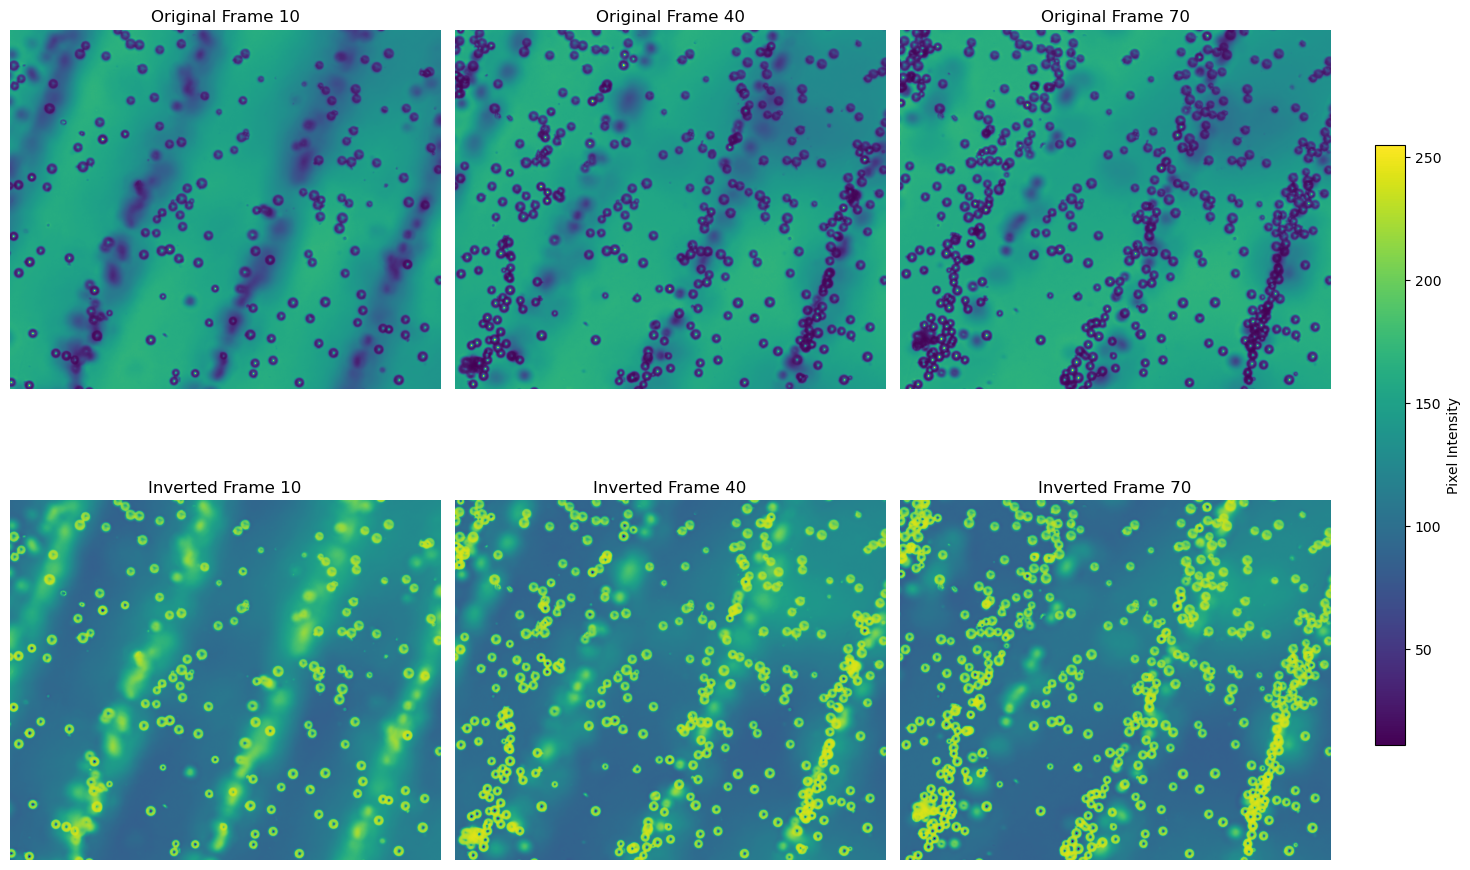

In [4]:
# Specify the frame indices we want to visualize
frame_indices = [10, 40, 70]  

# Normalize the color range for all frames
vmin, vmax = processed_frames.min(), processed_frames.max()  # Global min/max values for normalization
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = 'viridis'

# Create a figure with six subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

# Loop through the frames to plot both original and inverted
for i, frame_idx in enumerate(frame_indices):
    frame = processed_frames[frame_idx]
    inverted_frame = np.max(frame) - frame  # Invert the frame

    # Plot the original frame in the top row
    ax = axes[0, i]
    im = ax.imshow(frame, cmap=cmap, norm=norm)  # Apply normalization
    ax.set_title(f"Original Frame {frame_idx}")  # Add a title to indicate the frame number
    ax.axis('off')  # Hide axis labels

    # Plot the inverted frame in the bottom row
    ax = axes[1, i]
    ax.imshow(inverted_frame, cmap=cmap, norm=norm)  # Apply normalization
    ax.set_title(f"Inverted Frame {frame_idx}")  # Add a title for the inverted frame
    ax.axis('off')  # Hide axis labels

# Add a single shared colorbar at the right side of the figure
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label("Pixel Intensity")  # Label the colorbar

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
plt.show()


## Particle Tracking

### Using a histogram to analyze the intensity distribution of the frame and get an idea of the minmass parameter:

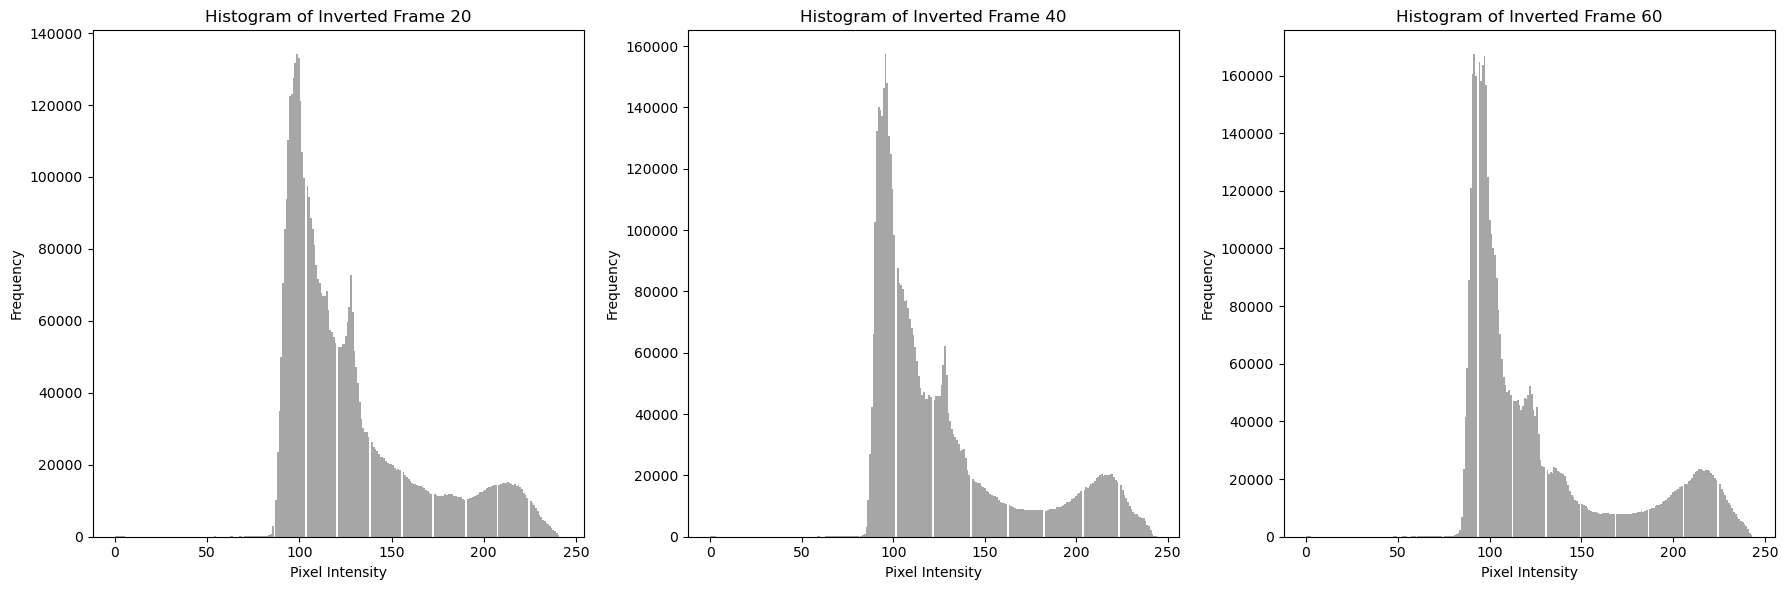

In [5]:
# Specify the frame indices you want to visualize
frame_indices = [20, 40, 60]  # Change these values to frames of interest

# Create a figure with 1 row and 3 columns (for the histograms)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Loop through the frame indices and plot the histograms
for i, frame_idx in enumerate(frame_indices):
    # Get the original frame
    frame = processed_frames[frame_idx]
    
    # Invert the frame to treat dark particles as "bright" ones for detection
    inverted_frame = np.max(frame) - frame
    
    # Plot the histogram of the inverted frame intensities
    ax = axes[i]
    ax.hist(inverted_frame.ravel(), bins=256, color='gray', alpha=0.7)
    ax.set_title(f'Histogram of Inverted Frame {frame_idx}')
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

# After examining the histograms, choose minmass based on the intensity values


### Check if that minmass threshold works in identifying the particles

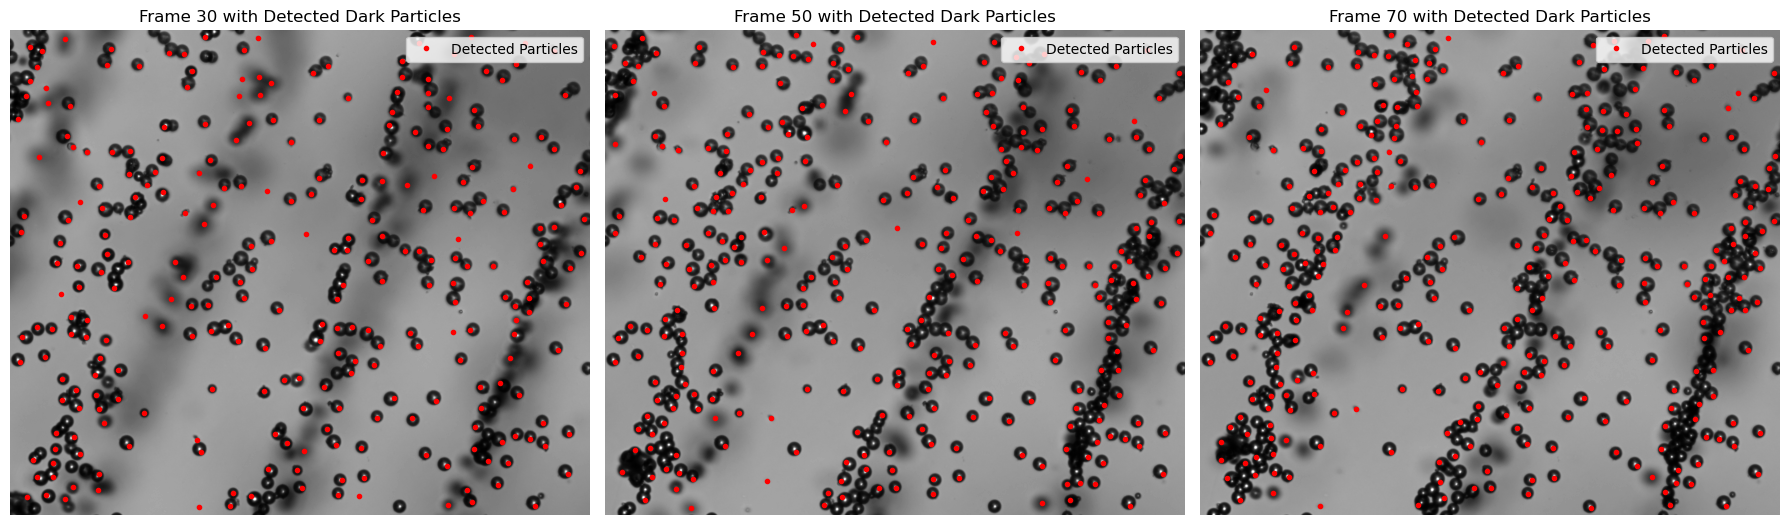

In [29]:
# Specify the frame indices we want to visualize
frame_indices = [30, 50, 70]  

# Create a figure with 1 row and 3 columns (for displaying frames with detected particles)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Loop through the frame indices and plot the frames with detected particles
for i, frame_idx in enumerate(frame_indices):
    # Get the original frame
    frame = processed_frames[frame_idx]
    
    # Invert the frame to treat dark particles as "bright" ones for detection
    inverted_frame = np.max(frame) - frame
    
    # Detect particles in the inverted frame
    diameter = 51  # Approximate particle diameter in pixels
    minmass = 180  # Minimum brightness of particles
    features = tp.locate(inverted_frame, diameter=diameter, minmass=minmass)

    # Plot the frame with detected particles overlaid
    ax = axes[i]
    ax.imshow(frame, cmap='gray')  # Display the original frame (dark particles on a light background)
    ax.set_title(f"Frame {frame_idx} with Detected Dark Particles")  # Add title
    ax.axis('off')  # Hide axis labels
    
    # Overlay the detected particles
    ax.plot(features['x'], features['y'], 'ro', markersize=3, label="Detected Particles")  # 'ro' creates red circles
    ax.legend(loc ='upper right')

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


### Particle tracking from frame-to-frame

Frame 77: 276 trajectories present.


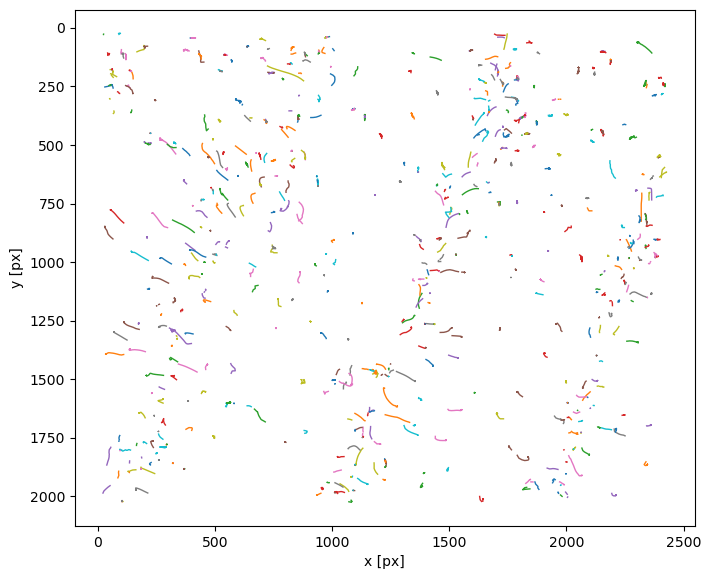

In [24]:
# Parameters
minmass = 180  # Adjust based on your data (minimum particle brightness)
search_range = 15  # Maximum displacement between frames (in pixels)
memory = 2  # Number of frames a particle can vanish before being considered lost


# Detect and link particles using trackpy
f = pd.DataFrame()
for i, frame in tqdm(enumerate(processed_frames), desc="Tracking particles"):
    # Detect particles in the current frame
    features = tp.locate(frame, diameter=51, minmass=minmass)
    features['frame'] = i
    f = pd.concat([f, features], ignore_index=True)

# Link particles across frames
linked = tp.link_df(f, search_range=search_range, memory=memory)

# Optional: Filter tracks by particle persistence or other criteria
filtered_tracks = tp.filter_stubs(linked, threshold=5)  # Keep tracks that persist at least 5 frames

# Visualize trajectories
fig, ax = plt.subplots(figsize=(8, 12))  # Create a figure and axes
tp.plot_traj(filtered_tracks, ax=ax)  # Pass the axes to the plot_traj function
ax.set_aspect('equal')  # Set equal axis scaling to ensure equal aspect ratio
plt.show()


### Overlaying the tracks on the first frame

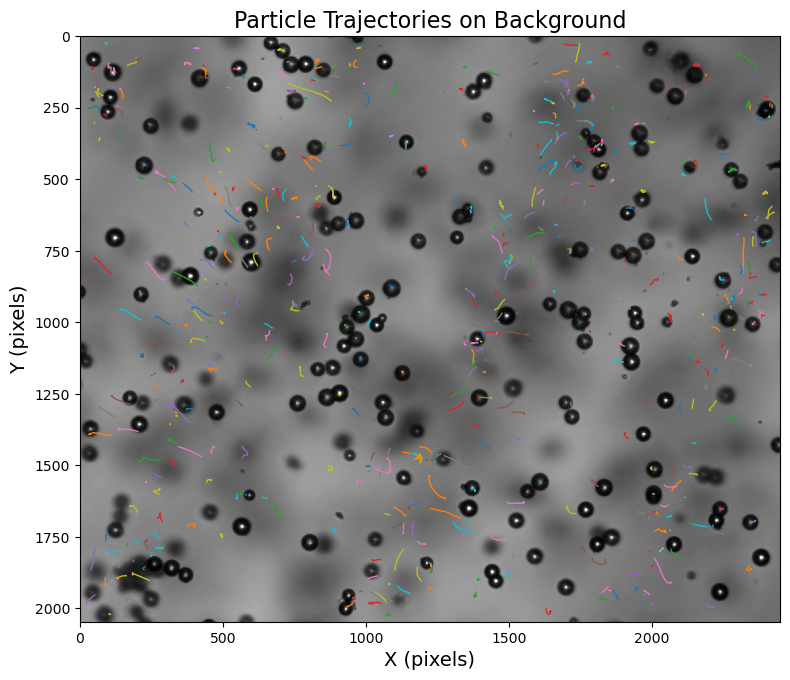

In [25]:
# Choose a frame for the background (e.g., the first frame of processed_frames)
background_image = processed_frames[0]  # Adjust this to the desired frame index or background

# Visualize the trajectories with the background image
fig, ax = plt.subplots(figsize=(8, 12))  # Create a figure and axes

# Plot trajectories, superimposing on the chosen background
tp.plot_traj(filtered_tracks, superimpose=background_image, ax=ax)

# Set equal axis scaling to ensure proper aspect ratio
ax.set_aspect('equal')

# Add axis labels and title for clarity
ax.set_xlabel("X (pixels)", fontsize=14)
ax.set_ylabel("Y (pixels)", fontsize=14)
ax.set_title("Particle Trajectories on Background", fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()


### Check how the tracks dataframe look like

In [59]:
filtered_tracks

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,x_shift,y_shift,frame_shift,displacement,inst_velocity
frame,,,,,,,,,,,,,,,
0,1115.419377,212.003691,6960.429451,17.626014,0.079523,10.436630,266669.0,0.080699,0,30,0.000000,0.000000,1.0,0.000000,0.000000
0,1177.391892,1127.567363,3920.961642,4.756714,0.125059,45.760609,76173.0,-0.072391,0,39,0.000000,0.000000,1.0,0.000000,0.000000
0,1558.609717,1606.404238,13979.464593,5.615281,0.071801,118.817019,95403.0,-0.089537,0,42,0.000000,0.000000,1.0,0.000000,0.000000
0,1263.453243,1395.183673,8851.065132,5.560437,0.059408,74.662046,92355.0,-0.086297,0,44,0.000000,0.000000,1.0,0.000000,0.000000
0,1264.521970,173.769654,8751.515737,4.109478,0.074844,133.267738,107558.0,-0.105303,0,45,0.000000,0.000000,1.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,661.102628,1665.130209,8513.566203,6.492972,0.094823,58.702515,71762.0,-0.262750,77,4299,-1.373805,-0.021608,3.0,1.373974,0.457991
77,650.556857,368.196612,4720.873275,4.324323,0.027260,62.105559,114077.0,-0.624283,77,1847,-0.060859,0.018042,1.0,0.063477,0.063477
77,625.893415,2324.641153,24353.036132,13.774631,0.229406,53.597949,223931.0,0.242710,77,3674,0.022845,-0.025744,1.0,0.034419,0.034419


### Save the tracks as a movie

In [28]:
# Define the helper functions (apply_cmap, nparray_to_video, make_tracks_movie) here...

def apply_cmap(data, cmap='gray', clim='auto'):
    """Apply a colormap to a numpy array."""
    if clim == 'auto':
        clim = data.min(), data.max()
    sm = ScalarMappable(Normalize(*clim, clip=True), cmap)
    rgba = [sm.to_rgba(d, bytes=True) for d in data]
    return rgba

def nparray_to_video(fname, data, clim='auto', cmap=None, codec='h264', fps=24, ffmpeg_params=['-pix_fmt', 'yuv420p']):
    """
    Save a 3D (t, y, x) numpy array to disk as a movie after applying a colormap.
    """
    dur = data.shape[0] / fps
    if cmap is not None:
        data_rgba = apply_cmap(data, cmap=cmap, clim=clim)
    else:
        data_rgba = data
    clip = ImageSequenceClip([d for d in data_rgba], fps=fps)
    clip.set_duration(dur).write_videofile(fname, audio=False, codec=codec, fps=fps, ffmpeg_params=ffmpeg_params)

def make_tracks_movie(imgs, tracks, save_name, fps=12, cmap='gray', clim='auto'):
    """
    Create a movie of the images with the tracks overlaid on top.

    Parameters
    ----------
    imgs : np.ndarray
        t+2D array of images (frames, height, width).
    tracks : pd.DataFrame
        DataFrame of tracks with columns ['x', 'y', 'frame', 'particle'].
    save_name : str
        Name of the file to save the movie to (e.g., 'movie.mp4').
    fps : int, optional
        Frames per second for the output movie.
    cmap : str, optional
        Colormap for the image frames.
    clim : tuple or 'auto', optional
        Color limits for the image intensity.
    """
    ims = []  # To store frame-by-frame images with overlaid tracks
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
    ax.axis('off')  # Turn off axis labels
    fig.tight_layout(pad=0)

    for i in trange(imgs.shape[0]):
        ax.imshow(imgs[i], cmap=cmap, animated=True)

        # Set clim (color limits) based on the 'auto' argument
        if clim == 'auto':
            clim = (np.min(imgs[i]), np.max(imgs[i]))  # Auto range based on the current frame's values
        ax.imshow(imgs[i], cmap=cmap, clim=clim, animated=True)

        for p in tracks['particle'].unique():
            particle_tracks = tracks[(tracks['particle'] == p) & (tracks['frame'] <= i)]
            ax.plot(particle_tracks['x'], particle_tracks['y'], color='red', lw=1)

        ax.scatter(
            tracks[tracks['frame'] == i]['x'], 
            tracks[tracks['frame'] == i]['y'], 
            color='black', s=2
        )

        ims.append(mplfig_to_npimage(fig))
        ax.clear()

    plt.close(fig)  # Close the figure to free memory
    video_data = np.array(ims)  # Convert the frames into a NumPy array
    nparray_to_video(save_name, video_data, clim=clim, cmap=cmap, codec='h264', fps=fps)

make_tracks_movie(processed_frames, filtered_tracks, data_folder+'\\tracked_movie.mp4', fps=12, cmap='gray', clim='auto')


100%|██████████| 78/78 [01:18<00:00,  1.01s/it]


Moviepy - Building video tracked_movie.mp4.
Moviepy - Writing video tracked_movie.mp4



Moviepy - Done !
Moviepy - video ready tracked_movie.mp4


### Track properties calculation function (velocities, length, duration)

In [35]:
def calculate_track_metrics(tp_trajectories_filtered, resolution=None, frame_interval=None):
    """
    Calculate and store instantaneous shifts, displacements, velocities, total track properties, 
    and other metrics for each particle's trajectory. Optionally scale to real-time and real-space units.

    Parameters:
    - tp_trajectories_filtered (pandas DataFrame): Particle tracking data with 'x', 'y', 'frame', and 'particle' columns.
    - resolution (float, optional): Spatial resolution to convert units (e.g., pixels to microns). Defaults to None (no scaling).
    - frame_interval (float, optional): Time interval between frames to calculate velocities and track duration. Defaults to None (no scaling).

    Returns:
    - tp_trajectories_filtered (pandas DataFrame): Input DataFrame with added columns:
        - 'x_shift': x-direction shift per frame for each particle.
        - 'y_shift': y-direction shift per frame for each particle.
        - 'frame_shift': Number of frames between positions in the trajectory.
        - 'displacement': Frame-to-frame displacement (Euclidean distance) in pixels.
        - 'inst_velocity': Instantaneous velocity per frame (#px./frame) for each particle.
    - track_properties (pandas DataFrame): Aggregated track-level metrics per particle, including:
        - 'track_length': Total track length (sum of displacements in pixels or microns).
        - 'track_duration': Total duration of each particle's trajectory (frames or seconds).
        - 'distance': Net displacement from initial to final position (pixels or microns).
        - 'avg_velocity': Average net velocity (net displacement divided by total duration, in frames or microns/min).
        - 'inst_velocity': Average instantaneous velocity (total track length divided by total duration, in frames or microns/min).
        - 'sinuosity': Measure of track straightness (track length divided by net displacement).
    """

    # Calculate Instantaneous Shifts (x, y, and frame)
    tp_trajectories_filtered['x_shift'] = (tp_trajectories_filtered.groupby('particle')['x'].diff().fillna(0)) 
    tp_trajectories_filtered['y_shift'] = (tp_trajectories_filtered.groupby('particle')['y'].diff().fillna(0)) 
    tp_trajectories_filtered['frame_shift'] = tp_trajectories_filtered.groupby('particle')['frame'].diff().fillna(1)
    
    # Calculate instantaneous displacement and velocity in pixels and frames
    tp_trajectories_filtered['displacement'] = np.sqrt(tp_trajectories_filtered['x_shift']**2 + tp_trajectories_filtered['y_shift']**2)
    tp_trajectories_filtered['inst_velocity'] = tp_trajectories_filtered['displacement'] / tp_trajectories_filtered['frame_shift']
    
    # Drop NaN values from displacement and velocity
    tp_trajectories_filtered.dropna(subset=['displacement', 'inst_velocity'], inplace=True)

    # Calculate track-level metrics: total distance traveled (track length), track duration, distance, average velocity, and sinuosity   
    
    # Calculate track length (total distance traversed) by summing displacements for each particle
    track_properties = tp_trajectories_filtered.groupby('particle')['displacement'].sum().reset_index()   
    track_properties['track_length'] = track_properties['displacement']  # Keep track length in pixels (no resolution conversion by default)
    
    # Dropping the 'displacement' column from the new dataframe
    track_properties = track_properties.drop(columns='displacement')
    
    # Calculate track duration (total frames)
    track_duration = tp_trajectories_filtered.groupby('particle')['frame'].nunique().reset_index(name='track_duration')
    
    # Merge the track_duration back into track_properties DataFrame
    track_properties = track_properties.merge(track_duration[['particle', 'track_duration']], on='particle', how='left')

    # Calculate total displacement (net distance between start and end positions) in pixels
    track_metrics = tp_trajectories_filtered.groupby('particle').agg(
        x_start=('x', 'first'),
        y_start=('y', 'first'),
        x_end=('x', 'last'),
        y_end=('y', 'last')
    ).reset_index()
    
    track_properties['distance'] = np.sqrt((track_metrics['x_end'] - track_metrics['x_start'])**2 +
                                            (track_metrics['y_end'] - track_metrics['y_start'])**2)
    
    # Calculate average net velocity (net displacement / total frames)
    track_properties['avg_velocity'] = track_properties['distance'] / track_properties['track_duration']
    
    # Calculate the average instantaneous velocity (track length / total frames)
    track_properties['inst_velocity'] = track_properties['track_length'] / track_properties['track_duration']

    # Calculate sinuosity (track length / net displacement)
    track_properties['sinuosity'] = track_properties['track_length'] / track_properties['distance']
    
    # If resolution and frame_interval are provided, scale the metrics to real-world units
    if resolution is not None and frame_interval is not None:
        track_properties['track_length'] /= resolution  # Convert track length to microns
        track_properties['distance'] /= resolution  # Convert distance to microns
        track_properties['avg_velocity'] *= 60 / frame_interval  # Convert avg_velocity to microns/min
        track_properties['inst_velocity'] *= 60 / frame_interval  # Convert inst_velocity to microns/min
    
    return tp_trajectories_filtered, track_properties


In [36]:
trajectories, track_metrics = calculate_track_metrics(filtered_tracks)
trajectories


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,x_shift,y_shift,frame_shift,displacement,inst_velocity
frame,,,,,,,,,,,,,,,
0,1115.419377,212.003691,6960.429451,17.626014,0.079523,10.436630,266669.0,0.080699,0,30,0.000000,0.000000,1.0,0.000000,0.000000
0,1177.391892,1127.567363,3920.961642,4.756714,0.125059,45.760609,76173.0,-0.072391,0,39,0.000000,0.000000,1.0,0.000000,0.000000
0,1558.609717,1606.404238,13979.464593,5.615281,0.071801,118.817019,95403.0,-0.089537,0,42,0.000000,0.000000,1.0,0.000000,0.000000
0,1263.453243,1395.183673,8851.065132,5.560437,0.059408,74.662046,92355.0,-0.086297,0,44,0.000000,0.000000,1.0,0.000000,0.000000
0,1264.521970,173.769654,8751.515737,4.109478,0.074844,133.267738,107558.0,-0.105303,0,45,0.000000,0.000000,1.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,661.102628,1665.130209,8513.566203,6.492972,0.094823,58.702515,71762.0,-0.262750,77,4299,-1.373805,-0.021608,3.0,1.373974,0.457991
77,650.556857,368.196612,4720.873275,4.324323,0.027260,62.105559,114077.0,-0.624283,77,1847,-0.060859,0.018042,1.0,0.063477,0.063477
77,625.893415,2324.641153,24353.036132,13.774631,0.229406,53.597949,223931.0,0.242710,77,3674,0.022845,-0.025744,1.0,0.034419,0.034419


### Track Metrics (Units are in pixels and frames)

In [37]:
track_metrics

,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity
0,30,45.219880,30,6.759792,0.225326,1.507329,6.689537
1,39,10.538759,78,4.261284,0.054632,0.135112,2.473142
2,42,7.310205,78,2.232411,0.028621,0.093721,3.274579
3,44,7.786779,12,0.683196,0.056933,0.648898,11.397573
4,45,5.734016,19,3.952003,0.208000,0.301790,1.450914
...,...,...,...,...,...,...,...
659,4375,0.330689,5,0.323414,0.064683,0.066138,1.022494
660,4377,7.299067,5,6.443018,1.288604,1.459813,1.132865
661,4380,6.768950,5,4.047924,0.809585,1.353790,1.672203
662,4381,26.832594,5,6.565603,1.313121,5.366519,4.086844


## Plotting the distributions
### Track duration distribution

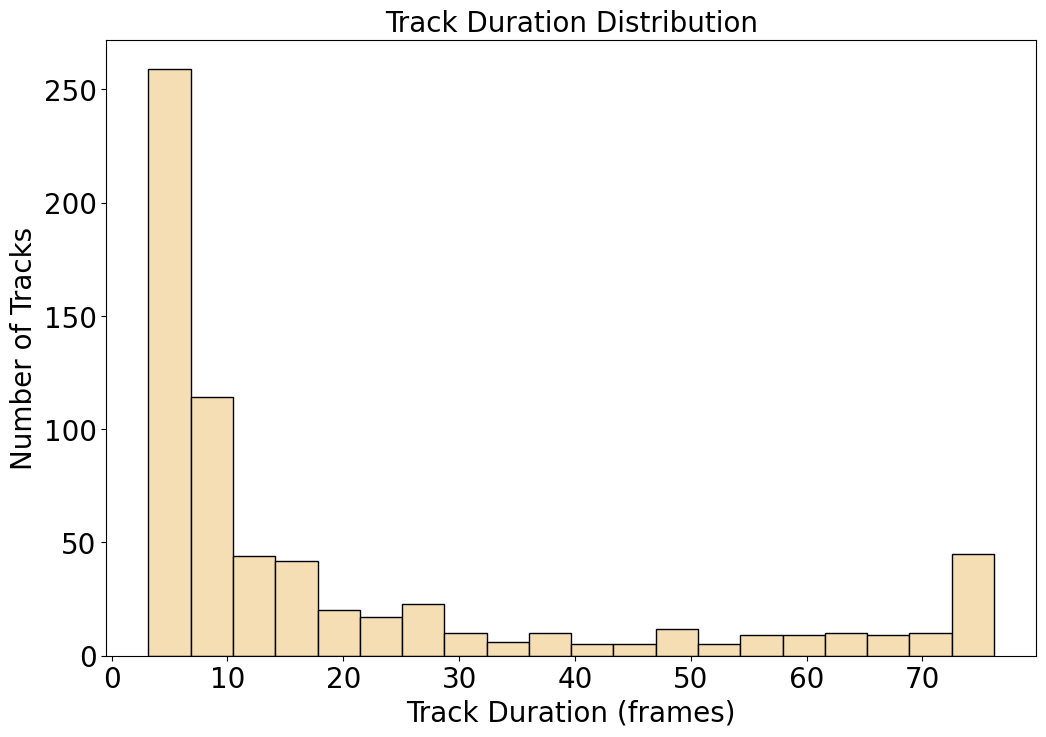

In [46]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(track_metrics['track_duration'], bins=20, color='wheat', edgecolor='k', align='left')
plt.title('Track Duration Distribution', fontsize=20)
plt.xlabel('Track Duration (frames)', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()



### Inverse sinuosity (measure of straightness of the tracks)

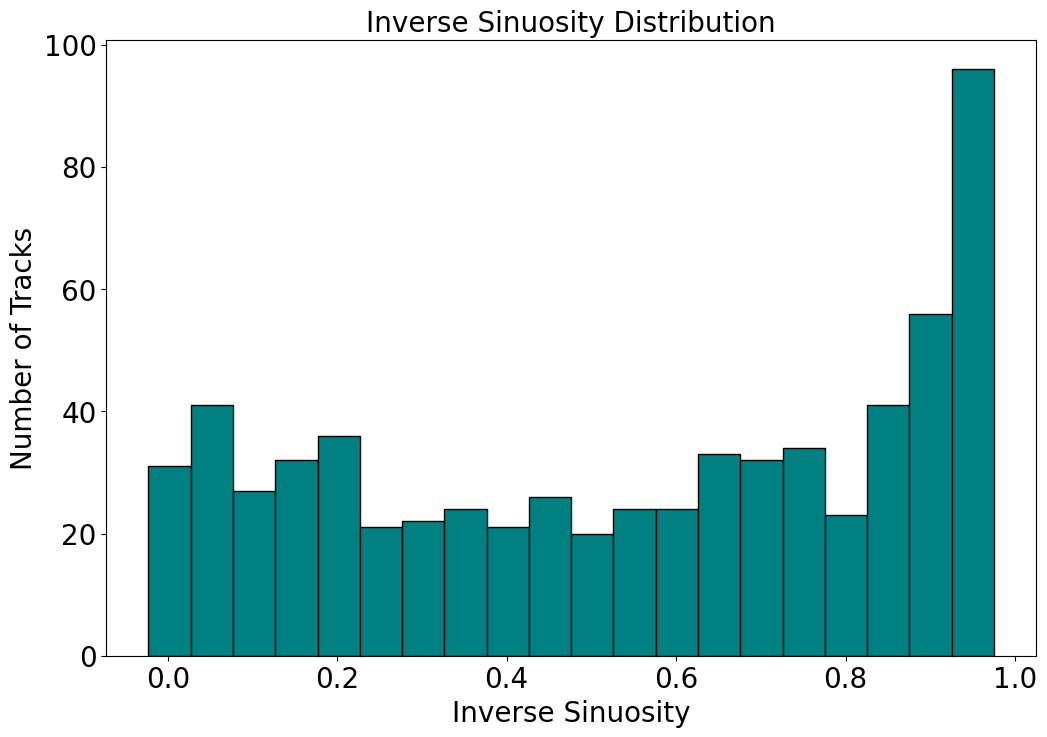

In [61]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(track_metrics['distance']/track_metrics['track_length'], bins=20, color='teal', edgecolor='k', align='left')
plt.title('Inverse Sinuosity Distribution', fontsize=20)
plt.xlabel('Inverse Sinuosity', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()


### Track total length (sum of frame to frame displacements) traversed distribution 

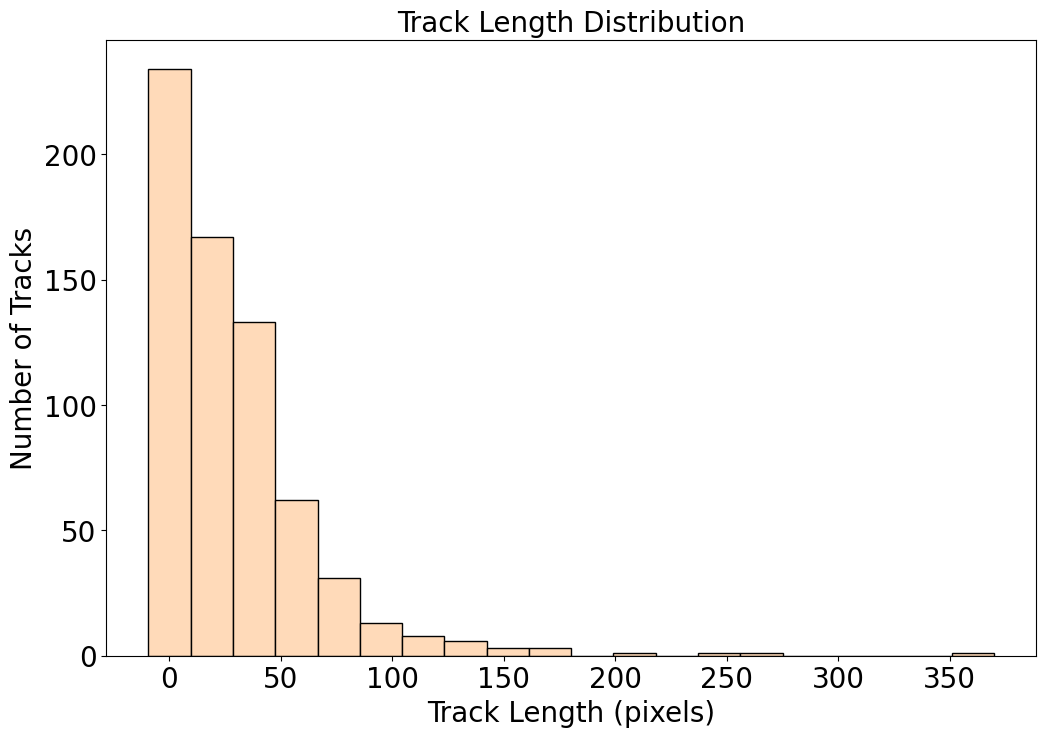

In [53]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(track_metrics['track_length'], bins=20, color='peachpuff', edgecolor='k', align='left')
plt.title('Track Length Distribution', fontsize=20)
plt.xlabel('Track Length (pixels)', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()


### Track speed distribution 

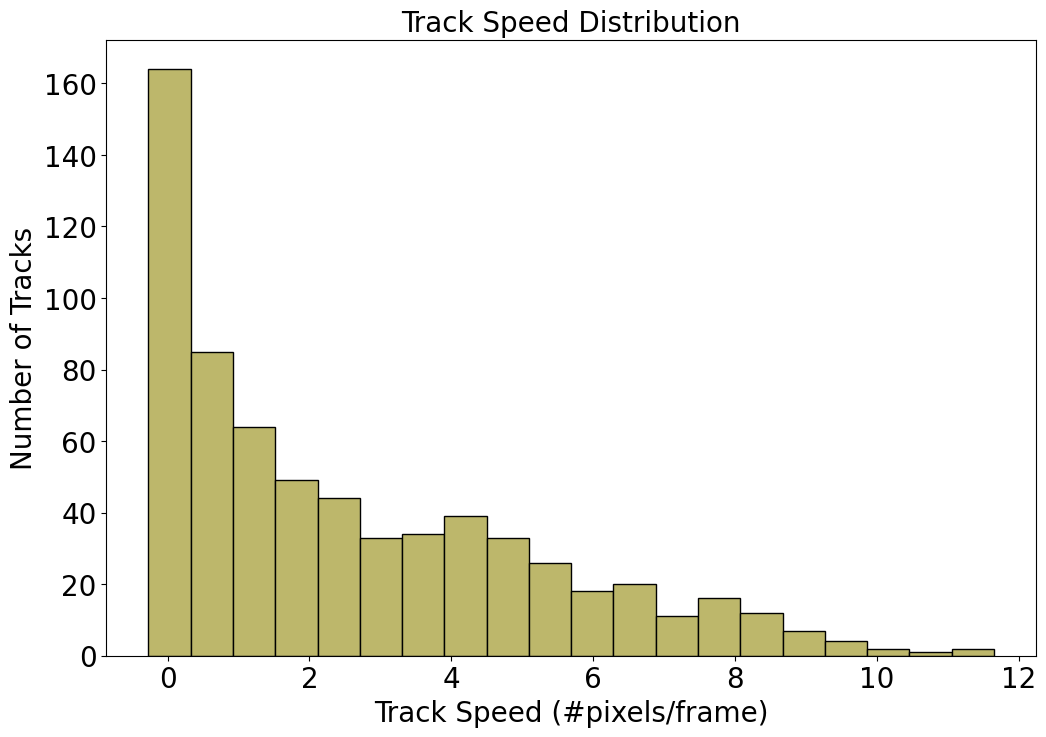

In [62]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(track_metrics['inst_velocity'], bins=20, color='darkkhaki', edgecolor='k', align='left')
plt.title('Track Speed Distribution', fontsize=20)
plt.xlabel('Track Speed (#pixels/frame)', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()


### Save the dataframes storing tracks and track metrics

In [57]:
# Save DataFrame to CSV
save_path = data_folder+'\\'
trajectories.to_csv(save_path+'trajectories.csv', index=False)
track_metrics.to_csv(save_path+'track_metrics.csv', index=False)